In [5]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt

from darts                             import TimeSeries, concatenate
from darts.models                      import NBEATSModel
from darts.dataprocessing.transformers import Scaler

from darts.metrics                     import mape, mae, mse
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

from sklearn.metrics import mean_squared_error
from torch.optim.lr_scheduler import MultiStepLR
from torchmetrics.regression import MeanAbsolutePercentageError
from torch.optim import Adam

import logging   
logging.disable(logging.CRITICAL)

### Pretraining with all countries

In [6]:
pdf = pd.read_csv("data/cleaned_monthly.csv",index_col=None)
pdf.index = pd.to_datetime(pdf['date'],utc=True)
pdf.index = pdf.index.tz_localize(None)  

pdf["y"] = (pdf["monthlySumMWh"])/1e6
pdf = pdf.drop(columns=["monthlySumMWh","date"])

In [7]:
for name, df in pdf.groupby("country"):
    split = len(df)-12
    globals()[name+"_train"] = TimeSeries.from_series(df.y.iloc[:split])
    globals()[name+"_test"]  = TimeSeries.from_series(df.y.iloc[split:])

all_countries = [globals()[name+"_train"] for name in np.unique(pdf.country)]

In [9]:
model = NBEATSModel(input_chunk_length=12, 
                    output_chunk_length=12, 
                    random_state=42,
                    num_blocks=3,
                    num_layers=3,
                    generic_architecture=True,
                    layer_widths=512,
                    loss_fn= MeanAbsolutePercentageError(),
                    lr_scheduler_cls = MultiStepLR,
                    lr_scheduler_kwargs= {"optimizer": Adam, "milestones":[15,17,19,21], "verbose": False, 'gamma':0.5 },
                    optimizer_kwargs={'lr': 1e-3},
                    force_reset=False
                    )

#batch_size=256, not sure how to do this. 

In [10]:
model.fit(all_countries, epochs=20, verbose=True)

Training: 0it [00:00, ?it/s]

C:\Users\ewzbusi\AppData\Roaming\Python\Python310\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=3, num_layers=3, layer_widths=512, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=12, output_chunk_length=12, random_state=42, loss_fn=MeanAbsolutePercentageError(), lr_scheduler_cls=<class 'torch.optim.lr_scheduler.MultiStepLR'>, lr_scheduler_kwargs={'optimizer': <class 'torch.optim.adam.Adam'>, 'milestones': [15, 17, 19, 21], 'verbose': False, 'gamma': 0.5}, optimizer_kwargs={'lr': 0.001}, force_reset=False)

MAE: 0.15986132380127996
MAPE: 3.081647873932424


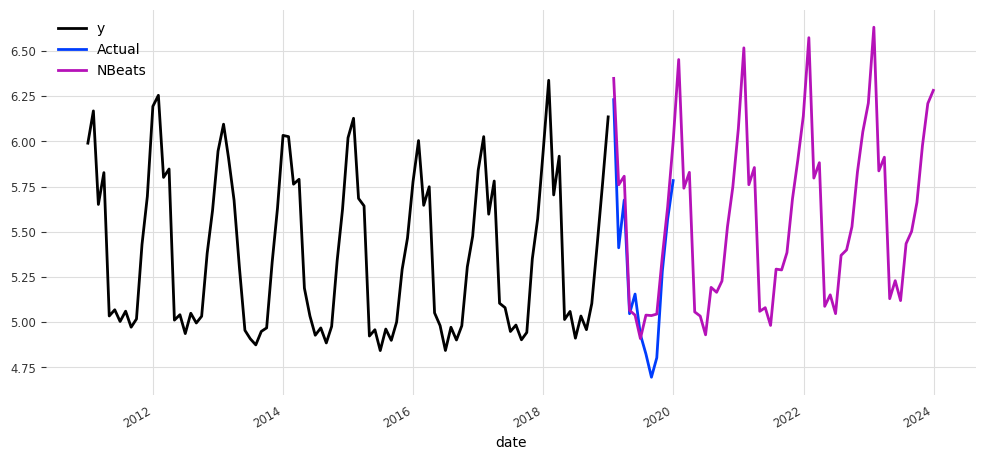

In [11]:
pred= model.predict(n=12*5, series=CH_train,verbose=False)
test = CH_test
hist = model.historical_forecasts(CH_train, start=0.1, retrain=False,  forecast_horizon=12, verbose=False)

plt.figure(101, figsize=(12, 5))
hist.plot()
test.plot(label='Actual')
pred.plot(label='NBeats')
print(f'MAE: {mae(test, pred)}')
print(f'MAPE: {mape(test, pred)}')

### Training with ZH data

In [12]:
pdf = pd.read_csv("../data/monthly/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)
pdf.index = pd.to_datetime(pdf['Timestamp'],utc=True)
pdf.index = pdf.index.tz_localize(None)  

pdf["y"] = pdf["NE7_GWh"].values
pdf = pdf.drop(columns=["Timestamp","NE5_GWh","NE7_GWh"])

split = len(pdf)-12
zh_train, zh_test = pdf.iloc[:split], pdf.iloc[split:]

ytrain = TimeSeries.from_dataframe(zh_train)
ytest  = TimeSeries.from_dataframe(zh_test)
ytotal = TimeSeries.from_dataframe(pdf)

In [13]:
model.fit(ytrain, epochs=50, verbose=True) #transfer learning would in theory not require training with out data

Training: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=3, num_layers=3, layer_widths=512, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=12, output_chunk_length=12, random_state=42, loss_fn=MeanAbsolutePercentageError(), lr_scheduler_cls=<class 'torch.optim.lr_scheduler.MultiStepLR'>, lr_scheduler_kwargs={'optimizer': <class 'torch.optim.adam.Adam'>, 'milestones': [15, 17, 19, 21], 'verbose': False, 'gamma': 0.5}, optimizer_kwargs={'lr': 0.001}, force_reset=False)

In [14]:
pred1= model.predict(n=len(ytest),  series=ytrain,verbose=False)
pred5= model.predict(n=12*5,        series=ytrain,verbose=False)
#hist = model.historical_forecasts(ytrain, start=0.2, retrain=False,  forecast_horizon=12, verbose=False)

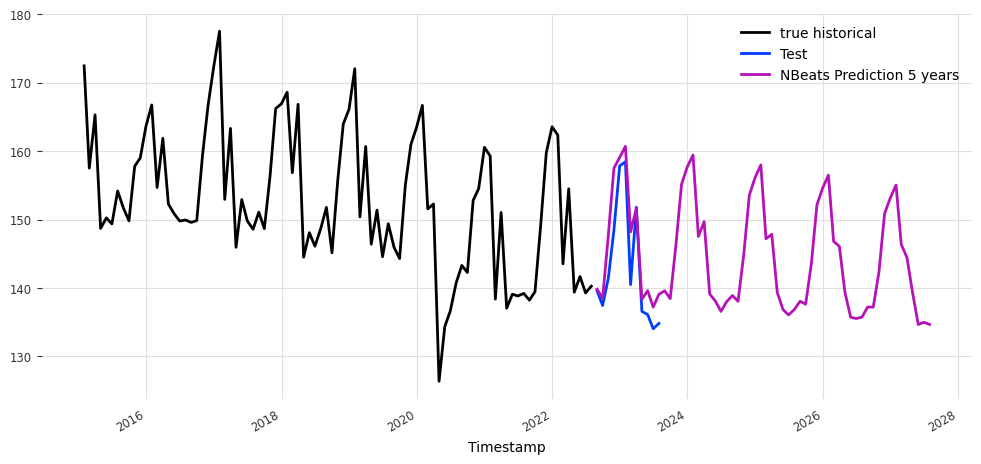

In [15]:
plt.figure(101, figsize=(12, 5))
#hist.plot(label='historical fit')
ytrain.plot(label='true historical')
ytest.plot(label='Test')
pred5.plot(label='NBeats Prediction 5 years')

In [ ]:
print(f'MAE:  {mae(ytest, pred1)}')
print(f'MAPE: {mape(ytest, pred1)}')
print(f'mse:  {mse(ytest, pred1)}')

MAE:  5.439634029959301
MAPE: 3.7952125129036762
mse:  52.109938795037976


In [ ]:
# #----------------ensemble----------
# from darts.models import RegressionEnsembleModel

# models = [NaiveDrift(), NaiveSeasonal(12)]

# ensemble_model = RegressionEnsembleModel(
#     forecasting_models=models, regression_train_n_points=12
# )

# backtest = ensemble_model.historical_forecasts(
#     series_air, start=0.6, forecast_horizon=3, verbose=True
# )

# print("MAPE = %.2f" % (mape(backtest, series_air)))
# series_air.plot()
# backtest.plot()